# **Training a Baseline CNN Model with Regional Multi-Year SST Anomaly Maps**

by Ding

Connect Google Drive.

In [134]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


Load the saved preprocessed datasets.

In [135]:
import json

with open('/gdrive/My Drive/GODAS/anomaly_sets_3_maps.txt', 'r') as in_file:
    data_sets = json.load(in_file)

In [136]:
import numpy as np

train_set_3 = np.array(data_sets[0])
test_set_3 = np.array(data_sets[1])
train_label = np.array(data_sets[2])
test_label = np.array(data_sets[3])

Simiarly, some details that have been explained in the privous notebook are omitted.

In [137]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as Data
from torch.autograd import Variable

In [138]:
train_data = []
test_data = []

for i in range(len(train_set_3)):
  train_data.append((torch.from_numpy(train_set_3[i]), torch.from_numpy(train_label[i])))

for i in range(len(test_set_3)):
  test_data.append((torch.from_numpy(test_set_3[i]), torch.from_numpy(test_label[i])))

In [139]:
print(len(train_data))
print(len(test_data))

391
95


In [140]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [141]:
EPOCH = 100
BATCH_SIZE = 16
LR = 0.00001

In [142]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_all_loader = Data.DataLoader(dataset=train_data, batch_size=391, shuffle=False)
test_loader = Data.DataLoader(dataset=test_data, batch_size=95, shuffle=False)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


Be sure to use the activiation functions that output negative values, such as the tangent hyperbolic function tanh().

In [143]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.Tanh(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.Tanh(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 1, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        output = self.conv3(x)
        #x = x.view(x.size(0), -1)
        #output = self.out(x)
        return output, x 

In [144]:
cnn = CNN().double()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
  (conv3): Sequential(
    (0): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
)


In [145]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.MSELoss() 

In [146]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)
        b_y = Variable(y)

        output = cnn(b_x)[0]
        #output = output.reshape(-1)
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for step, (x, y) in enumerate(train_all_loader):
        c_x = Variable(x)
        c_y = Variable(y)

    for step, (x, y) in enumerate(test_loader):
        d_x = Variable(x)
        d_y = Variable(y)

        if step % 100 == 0:
            
            pred_train_y, last_layer = cnn(c_x)
            train_mse = loss_func(pred_train_y, c_y)

            pred_test_y, last_layer = cnn(d_x)
            test_mse = loss_func(pred_test_y, d_y)

            print('Epoch: ', epoch, '| trainig loss: %.4f' % loss.data, '| training MSE: %.4f' % train_mse, '| test MSE: %.4f' % test_mse)

Epoch:  0 | trainig loss: 0.2436 | training MSE: 0.2378 | test MSE: 0.4949
Epoch:  1 | trainig loss: 0.2410 | training MSE: 0.2264 | test MSE: 0.4623
Epoch:  2 | trainig loss: 0.1770 | training MSE: 0.2159 | test MSE: 0.4320
Epoch:  3 | trainig loss: 0.0631 | training MSE: 0.2071 | test MSE: 0.4057
Epoch:  4 | trainig loss: 0.2575 | training MSE: 0.1996 | test MSE: 0.3830
Epoch:  5 | trainig loss: 0.1590 | training MSE: 0.1931 | test MSE: 0.3630
Epoch:  6 | trainig loss: 0.1727 | training MSE: 0.1871 | test MSE: 0.3442
Epoch:  7 | trainig loss: 0.1645 | training MSE: 0.1824 | test MSE: 0.3298
Epoch:  8 | trainig loss: 0.2291 | training MSE: 0.1779 | test MSE: 0.3156
Epoch:  9 | trainig loss: 0.1882 | training MSE: 0.1739 | test MSE: 0.3032
Epoch:  10 | trainig loss: 0.1286 | training MSE: 0.1704 | test MSE: 0.2928
Epoch:  11 | trainig loss: 0.1080 | training MSE: 0.1675 | test MSE: 0.2838
Epoch:  12 | trainig loss: 0.2123 | training MSE: 0.1647 | test MSE: 0.2757
Epoch:  13 | trainig l

In [147]:
print(type(pred_test_y))
print(pred_test_y.shape)
print(pred_test_y)

<class 'torch.Tensor'>
torch.Size([95, 1, 30, 10])
tensor([[[[-8.0830e-02, -1.7776e-01, -1.6100e-01,  ..., -4.9637e-02,
           -3.3443e-02, -3.1255e-02],
          [-1.3690e-01, -2.5660e-01, -2.4801e-01,  ..., -7.3221e-02,
           -2.3722e-02, -5.0684e-03],
          [-1.3052e-01, -2.1607e-01, -2.2000e-01,  ..., -2.8455e-02,
            2.1545e-02,  2.9644e-02],
          ...,
          [-1.4223e-02, -3.3997e-02, -3.2520e-02,  ...,  5.2583e-01,
            4.1192e-01,  2.2336e-01],
          [-1.1344e-02, -3.0682e-02, -2.3693e-02,  ...,  5.0303e-01,
            4.2883e-01,  2.4830e-01],
          [-1.4350e-02, -1.7689e-02, -2.0690e-02,  ...,  2.8884e-01,
            2.7076e-01,  1.6198e-01]]],


        [[[ 1.6259e-01,  3.3281e-01,  4.1717e-01,  ...,  5.3648e-01,
            4.9331e-01,  3.1948e-01],
          [ 2.8169e-01,  4.1745e-01,  5.7256e-01,  ...,  7.3177e-01,
            6.9404e-01,  5.2715e-01],
          [ 2.6525e-01,  3.0221e-01,  5.2792e-01,  ...,  7.6573e-01,
     

In [148]:
print(type(d_y))
print(d_y.shape)
print(d_y)

<class 'torch.Tensor'>
torch.Size([95, 1, 30, 10])
tensor([[[[ 6.2536e-01,  5.8061e-01,  6.6285e-01,  ...,  7.5132e-01,
            7.1064e-01,  6.1276e-01],
          [ 6.3944e-01,  5.7550e-01,  6.6355e-01,  ...,  8.2139e-01,
            7.8756e-01,  6.8570e-01],
          [ 6.3832e-01,  0.0000e+00,  6.5160e-01,  ...,  8.6377e-01,
            8.3471e-01,  7.3221e-01],
          ...,
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -7.0090e-02,
           -1.0556e-01, -1.0924e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5822e-01,
           -1.5573e-01, -1.3381e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -2.6326e-01,
           -2.1767e-01, -1.6088e-01]]],


        [[[ 1.3124e+00,  1.3704e+00,  1.4696e+00,  ...,  1.3076e+00,
            1.2208e+00,  1.1248e+00],
          [ 1.3903e+00,  1.4506e+00,  1.5430e+00,  ...,  1.3910e+00,
            1.2979e+00,  1.1949e+00],
          [ 1.4542e+00,  0.0000e+00,  1.5609e+00,  ...,  1.4251e+00,
     

In [149]:
pred_test_y_array = np.squeeze(pred_test_y.detach().cpu().numpy())
test_y_array = np.squeeze(test_label, axis=1)

Index: 30
Index: 78
Index: 62
Index: 10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  


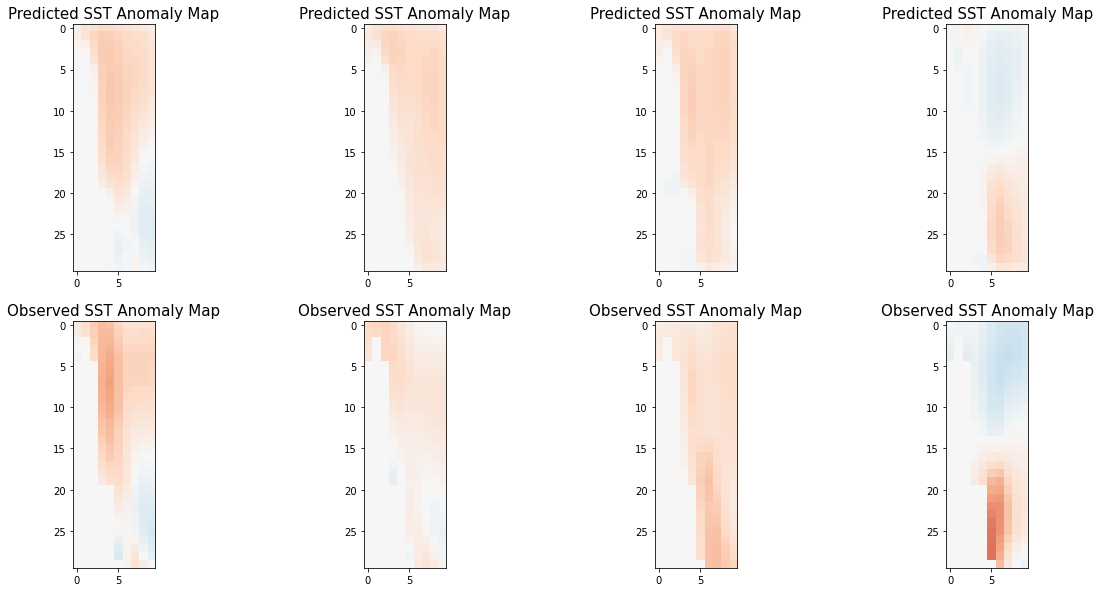

In [155]:
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import random

def plot_map(index, y, pred, axx):
  norm = DivergingNorm(vcenter=0, vmax=3, vmin=-3)
  if pred == True:
    axx.imshow(y[index], cmap = 'RdBu_r', norm=norm, interpolation='none')
    axx.set_title('Predicted SST Anomaly Map', fontsize=15)
  else:
    axx.imshow(y[index], cmap = 'RdBu_r', norm=norm, interpolation='none')
    axx.set_title('Observed SST Anomaly Map', fontsize=15)

rand_index = random.sample(range(0, len(pred_test_y_array)), 4)
fig, ax = plt.subplots(nrows=2,  ncols=4, figsize=(20, 10))
j = 0

for i in rand_index:
  print('Index: ' + str(i))
  plot_map(i, pred_test_y_array, True, ax[0][j])
  plot_map(i, test_y_array, False, ax[1][j])
  j += 1

Then, we train another model, using one month anomaly map to predict the average SST value in the next month.

In [62]:
with open('/gdrive/My Drive/GODAS/anomaly_sets_1_values.txt', 'r') as in_file:
    data_sets = json.load(in_file)

In [63]:
train_set = np.array(data_sets[0])
test_set = np.array(data_sets[1])
train_label = np.array(data_sets[2])
test_label = np.array(data_sets[3])

In [64]:
print(train_set.shape)
print(test_set.shape)
print(train_label.shape)
print(test_label.shape)

(393, 1, 30, 10)
(97, 1, 30, 10)
(393,)
(97,)


In [65]:
train_data = []
test_data = []

for i in range(len(train_set)):
  train_data.append((torch.from_numpy(train_set[i]), train_label[i]))

for i in range(len(test_set)):
  test_data.append((torch.from_numpy(test_set[i]), test_label[i]))

In [66]:
EPOCH = 50
BATCH_SIZE = 8
LR = 0.00001

In [67]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

train_all_loader = Data.DataLoader(dataset=train_data, batch_size=393, shuffle=False)
test_loader = Data.DataLoader(dataset=test_data, batch_size=97, shuffle=False)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [68]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, 1, 1),
            nn.Tanh(),
        )
        self.out = nn.Linear(16 * 15 * 5, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x 

In [69]:
cnn = CNN().double()

print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
  (out): Linear(in_features=1200, out_features=1, bias=True)
)


In [70]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = nn.MSELoss() 

In [71]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x)
        b_y = Variable(y)

        output = cnn(b_x)[0]
        output = output.reshape(-1) # To avoid different sizes
        loss = loss_func(output, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for step, (x, y) in enumerate(train_all_loader):
        c_x = Variable(x)
        c_y = Variable(y)

    for step, (x, y) in enumerate(test_loader):
        d_x = Variable(x)
        d_y = Variable(y)

        if step % 100 == 0:
            
            pred_train_y, last_layer = cnn(c_x)
            train_mse = loss_func(pred_train_y, c_y)

            pred_test_y, last_layer = cnn(d_x)
            test_mse = loss_func(pred_test_y, d_y)

            print('Epoch: ', epoch, '| trainig loss: %.4f' % loss.data, '| training MSE: %.4f' % train_mse, '| test MSE: %.4f' % test_mse)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([393])) that is different to the input size (torch.Size([393, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([97])) that is different to the input size (torch.Size([97, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch:  0 | trainig loss: 0.1001 | training MSE: 0.3409 | test MSE: 0.6129
Epoch:  1 | trainig loss: 0.0239 | training MSE: 0.3372 | test MSE: 0.5724
Epoch:  2 | trainig loss: 0.4438 | training MSE: 0.3434 | test MSE: 0.5371
Epoch:  3 | trainig loss: 0.1347 | training MSE: 0.3576 | test MSE: 0.5037
Epoch:  4 | trainig loss: 0.0987 | training MSE: 0.3756 | test MSE: 0.4821
Epoch:  5 | trainig loss: 0.1030 | training MSE: 0.3955 | test MSE: 0.4658
Epoch:  6 | trainig loss: 0.0023 | training MSE: 0.4170 | test MSE: 0.4511
Epoch:  7 | trainig loss: 0.0004 | training MSE: 0.4340 | test MSE: 0.4351
Epoch:  8 | trainig loss: 0.0332 | training MSE: 0.4481 | test MSE: 0.4269
Epoch:  9 | trainig loss: 0.2654 | training MSE: 0.4606 | test MSE: 0.4212
Epoch:  10 | trainig loss: 0.1404 | training MSE: 0.4694 | test MSE: 0.4135
Epoch:  11 | trainig loss: 0.0237 | training MSE: 0.4786 | test MSE: 0.4092
Epoch:  12 | trainig loss: 0.1104 | training MSE: 0.4771 | test MSE: 0.4097
Epoch:  13 | trainig l

In [72]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

def plot_data(pred_y, real_y):
  
  pred_y = np.squeeze(pred_y.detach().cpu().numpy())

  fig, ax = plt.subplots(figsize=(9, 9))

  ax.set_xlim([-2.5, 2.5])
  ax.set_ylim([-2.5, 2.5])
  plt.xlabel('Observed Regional Average SST Anomaly', fontsize=20)
  plt.ylabel('Predicted Regional Average SST Anomaly', fontsize=20)
  ax.plot(real_y, pred_y, 'o', color='black')

  line = mlines.Line2D([0, 1], [0, 1], color='red')
  transform = ax.transAxes
  line.set_transform(transform)
  ax.add_line(line)

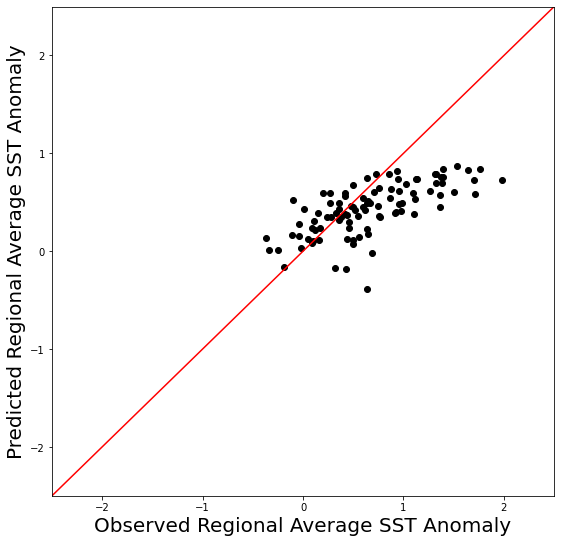

In [73]:
plot_data(pred_test_y, test_label)

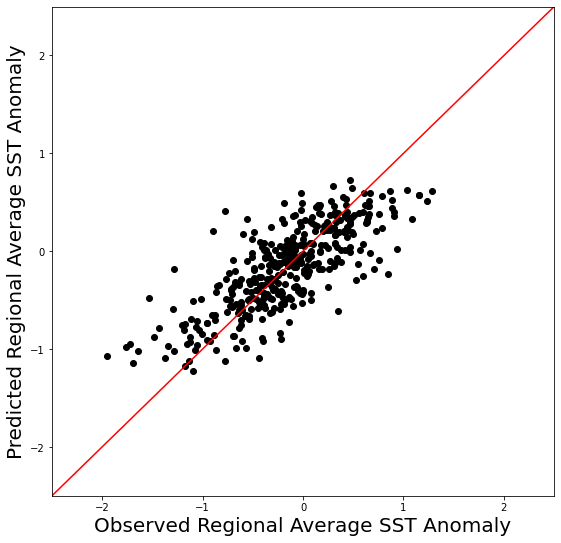

In [74]:
plot_data(pred_train_y, train_label)

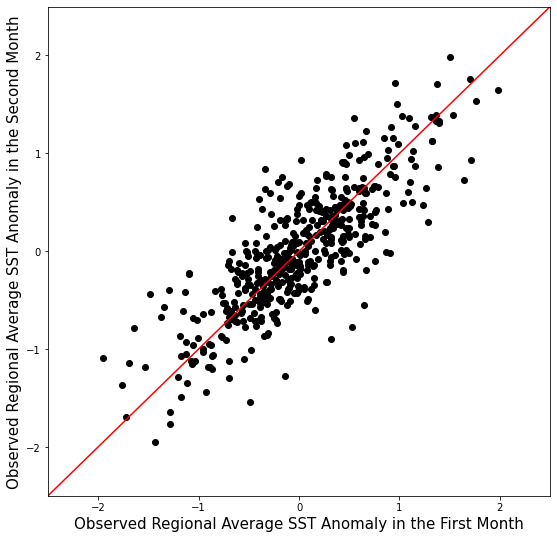

In [75]:
all_label_list = train_label.tolist() + test_label.tolist()

fig, ax = plt.subplots(figsize=(9, 9))

ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
plt.xlabel('Observed Regional Average SST Anomaly in the First Month', fontsize=15)
plt.ylabel('Observed Regional Average SST Anomaly in the Second Month', fontsize=15)
ax.plot(np.array(all_label_list[:-2]), np.array(all_label_list[1:-1]), 'o', color='black')

line = mlines.Line2D([0, 1], [0, 1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)